# Hippocampus

## Pattern separation

Define DG block

In [418]:
import torch
import torch.nn as nn
import torch.optim as optim

class DGModel(nn.Module):
    """
    Goal: separation
    Methods: sparsity
    """
    
    def __init__(self, input_size, output_size):
        super(DGModel, self).__init__()
        hidden_layer_size = input_size + output_size // 2
        # self.fc1 = nn.Linear(input_size, hidden_layer_size)
        # self.fc2 = nn.Linear(hidden_layer_size, output_size)
        self.fc1 = nn.Linear(input_size, output_size)
        
        # Weight initialization (Xavier)
        nn.init.xavier_uniform_(self.fc1.weight)
        # nn.init.xavier_uniform_(self.fc2.weight)
        self.k = 10  # Number of top activations to keep
        
    def forward(self, x):
        with torch.no_grad():  # Ensure no gradients are calculated for this model
            x = self.fc1(x)
            x = torch.tanh(x)  # Using tanh activation
            # x = self.fc2(x)
            # x = torch.relu(x)
            # Top-k sparsity: keep only top-k values, set others to zero
            mask = torch.zeros_like(x)
            _, topk_indices = torch.topk(x, self.k)
            mask.scatter_(0, topk_indices, 1)
            x = x * mask
        return x


We need some data to test these blocks

In [419]:
import math

w = 5
h = 5
sk = 5
w_s = w * sk
h_s = h * sk

# dg_model - Sparse encoding
N = w * h  # Input size
M = w_s * h_s   # Output size

# ec_to_ca3_model - Correcting encoding
H = N  # Input size
L = M   # Output size ?? M ??

# ca3_memory_model
T = M # or L # Input size
K = T # Output size = Input size

# ca1_model
input_size = N + K # the original input pattern + memory
hidden_size = math.floor(input_size * 0.7)  # Size of hidden layer
output_size = N  # Same as input size for reconstruction

# super simple ARC-like example
input_1 = torch.tensor([[[[0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0]]]], dtype=torch.float)

output_1 = torch.tensor([[[[0, 0, 1, 0, 0],
                           [0, 0, 1, 0, 0],
                           [1, 1, 1, 1, 1],
                           [0, 0, 1, 0, 0],
                           [0, 0, 1, 0, 0]]]], dtype=torch.float)

input_2 = torch.tensor([[[[0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1]]]], dtype=torch.float)

output_2 = torch.tensor([[[[0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1],
                           [1, 1, 1, 1, 1]]]], dtype=torch.float)

We are going to work with 1D arrays. 

DG block creates a sparse representation of the input

In [420]:
dg_model = DGModel(N, M)

def forward_dg_model(dg_model, x):
    return dg_model(x.flatten())


In [421]:
x = input_1.flatten()
xx = input_2.flatten()

y = forward_dg_model(dg_model, x)
yy = forward_dg_model(dg_model, xx)

print(y)
print(y.shape)

tensor([0.0000, -0.0000, 0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, 0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0000, 0.0000, 0.0000, -0.0000,
        0.0000, 0.0000, 0.0000, -0.0000, -0.0000, 0.0000, -0.0000, -0.0000, 0.0000,
        0.0000, -0.0000, -0.0000, 0.0000, 0.0000, 0.2542, -0.0000, 0.0000, -0.0000,
        0.0000, -0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0000, -0.0000,
        -0.0000, -0.0000, 0.0000, -0.0000, -0.0000, -0.0000, 0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000, 0.2419, -0.0000,
        -0.0000, -0.0000, -0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0000,
        0.0000, -0.0000, 0.0000, 0.0000, -0.0000, 0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, 0.0000, 0.0000, -0.0000, 0.0000, -0.0000,
        0.0000, -0.0000, 0.0000, 0.0000, 0.0000, -0.0000, 0.0000,

Before the sparse representation hits the memory
we need to add one independent network between the same input and the memory in parallel.
This will be used later as part of retrieval.
Its gould would be to help balance between sparse representation and real input and select important regions 
(that would help with ignoring noise (or with detecting invariants))

We add an Encoding model

In [422]:
class EncodingModel(nn.Module):
    """
    Goal: pattern retrieval
    Methods: compare sparse representation with the original
    """
    
    def __init__(self, input_size, output_size):
        super(EncodingModel, self).__init__()
        hidden_layer_size = output_size
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [423]:
ec_model = EncodingModel(H, L)
ec_optimizer = optim.AdamW(ec_model.parameters(), lr=0.0001)
ec_criterion = nn.MSELoss() # good for comparing pixel values

def forward_ec_to_ca3_model(ec_model, x):
    return ec_model(x)

def train_ec_to_ca3_model(ec_model, x, y):
    # Zero the parameter gradients
    ec_optimizer.zero_grad()

    # Compare reconstruction with the original input
    
    z = forward_ec_to_ca3_model(ec_model, x)
    loss = ec_criterion(z, y)

    # Backward pass: compute gradients
    loss.backward()

    # Optimization step: update weights
    ec_optimizer.step()

    print("Loss:", loss.item())
    # print("EC -> CA3 output:", z)
    
    return z, loss.item()


In [424]:
for i in range(500):
    print(i, "train_ec_to_ca3")
    z, loss1 = train_ec_to_ca3_model(ec_model, x, y)
    zz, loss2 = train_ec_to_ca3_model(ec_model, xx, yy)
    loss = (loss1 + loss2) / 2.0
    if loss < 0.0001:
        break

0 train_ec_to_ca3
Loss: 0.00606670742854476
Loss: 0.006500680465251207
1 train_ec_to_ca3
Loss: 0.005231458228081465
Loss: 0.005776952486485243
2 train_ec_to_ca3
Loss: 0.00457042595371604
Loss: 0.005115809850394726
3 train_ec_to_ca3
Loss: 0.004004669841378927
Loss: 0.00452616810798645
4 train_ec_to_ca3
Loss: 0.0035171955823898315
Loss: 0.004006020724773407
5 train_ec_to_ca3
Loss: 0.003097115783020854
Loss: 0.0035502719692885876
6 train_ec_to_ca3
Loss: 0.0027352706529200077
Loss: 0.0031526002567261457
7 train_ec_to_ca3
Loss: 0.002423564437776804
Loss: 0.0028063091449439526
8 train_ec_to_ca3
Loss: 0.002154933288693428
Loss: 0.002504818607121706
9 train_ec_to_ca3
Loss: 0.0019232169725000858
Loss: 0.0022420657332986593
10 train_ec_to_ca3
Loss: 0.0017230421071872115
Loss: 0.002012707060202956
11 train_ec_to_ca3
Loss: 0.0015497725689783692
Loss: 0.0018121096072718501
12 train_ec_to_ca3
Loss: 0.0013994432520121336
Loss: 0.0016362795140594244
13 train_ec_to_ca3
Loss: 0.0012686700792983174
Loss:

Loss: 0.0005835042102262378
25 train_ec_to_ca3
Loss: 0.0004920748760923743
Loss: 0.0005418701912276447
26 train_ec_to_ca3
Loss: 0.00046004829346202314
Loss: 0.0005038736271671951
27 train_ec_to_ca3
Loss: 0.0004305627371650189
Loss: 0.0004691212088800967
28 train_ec_to_ca3
Loss: 0.0004033591831102967
Loss: 0.00043726101284846663
29 train_ec_to_ca3
Loss: 0.00037820960278622806
Loss: 0.0004079821228515357
30 train_ec_to_ca3
Loss: 0.000354916846845299
Loss: 0.0003810141934081912
31 train_ec_to_ca3
Loss: 0.0003333110362291336
Loss: 0.00035612229839898646
32 train_ec_to_ca3
Loss: 0.000313244090648368
Loss: 0.0003330999752506614
33 train_ec_to_ca3
Loss: 0.00029458379140123725
Loss: 0.0003117651503998786
34 train_ec_to_ca3
Loss: 0.00027720892103388906
Loss: 0.000291957869194448
35 train_ec_to_ca3
Loss: 0.0002610084193293005
Loss: 0.00027353785117156804
36 train_ec_to_ca3
Loss: 0.0002458792587276548
Loss: 0.0002563803573139012
37 train_ec_to_ca3
Loss: 0.00023172609508037567
Loss: 0.000240375215

## Memory

This is where patterns are stored. Associative memory is implemented by classic Hopfield networks (there are also Modern Hopfield Networks that pose as a generalization of Transformers, that is not what is used here :( )

In [425]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

class HopfieldNetworkTorch(nn.Module):
    def __init__(self, num_neurons):
        super(HopfieldNetworkTorch, self).__init__()
        self.num_neurons = num_neurons
        self.weights = torch.zeros(num_neurons, num_neurons)

    def store_patterns(self, patterns):
        """
        Store patterns into the weight matrix using Hebbian learning.
        Patterns should be a tensor of shape (num_patterns, num_neurons).
        """
        num_patterns = patterns.size(0)
        for i in range(num_patterns):
            p = patterns[i].unsqueeze(1)  # Make it a column vector
            self.weights += torch.mm(p, p.T)  # Hebbian learning rule
        # Ensure weights on the diagonal are zero
        self.weights.fill_diagonal_(0)
        self.weights /= num_patterns  # Normalize by the number of patterns
    
    def store_pattern(self, pattern):
        p = pattern.unsqueeze(1) # Make it a column vector
        self.weights += torch.mm(p, p.T) # Hebbian learning rule
        # Ensure weights on the diagonal are zero
        self.weights.fill_diagonal_(0)

    def forward(self, input_state, max_steps=1000):
        """
        Forward pass: iteratively update the states of the network.
        Returns early if a stable state is reached.
        """
        with torch.no_grad():  # Ensure no gradients are calculated for this model
            state = input_state.clone()
            prev_state = state.clone()

            for i in range(max_steps):
                # Update all neurons at once for simplicity
                net_input = torch.matmul(self.weights, state)  # Weighted sum of inputs
                state = torch.tanh(net_input)  # Continuous activation (differentiable)
            
                # For each neuron, update its state
                # for i in range(self.num_neurons):
                #     net_input = torch.dot(self.weights[i], state)  # Weighted sum of inputs
                #     state[i] = 1 if net_input >= 0 else -1  # Update rule (sign function)

                # Early stopping if state does not change
                if torch.equal(state, prev_state):
                    break
                
                if i == max_steps - 1:
                    print(f'{max_steps} steps is not enough')
                prev_state = state.clone()

            return state
      
    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.weights.detach().numpy(), cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        plt.show()

torch.Size([1250])


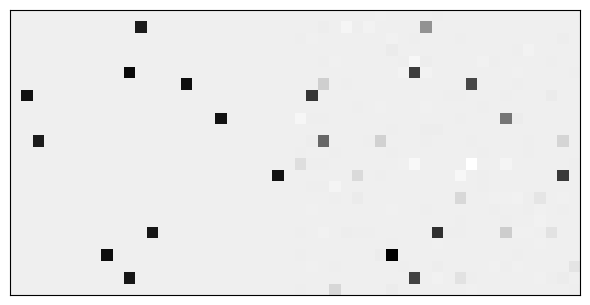

tensor([ 0.0000e+00, -0.0000e+00,  0.0000e+00,  ...,  1.2747e-02,
        -8.4411e-05,  8.9037e-04], grad_fn=<CatBackward0>)

In [426]:
# Plot the figure
plt.figure(figsize=(6, 4))
yz = torch.cat([y, z])
print(yz.shape)
plt.imshow(yz.detach().view(2*w_s, h_s).T, cmap=plt.cm.gray_r)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()
yz

In [427]:

hopfield_model = HopfieldNetworkTorch(T)

def forward_ca3_memory_model(hopfield_model, pp):
    u = hopfield_model(pp)
    return u

def train_ca3_memory_model(hopfield_model, y, z):
    # ca3_input = torch.cat([y, z]).clone().detach()
    # for i in range(5):
    hopfield_model.store_pattern(z)
    # hopfield_model.store_patterns(torch.stack([y, y, y, y]))
    u = forward_ca3_memory_model(hopfield_model, z)
    return u


In [428]:
for i in range (2):
    u = train_ca3_memory_model(hopfield_model, y, z)

for i in range (2):
    uu = train_ca3_memory_model(hopfield_model, yy, zz)

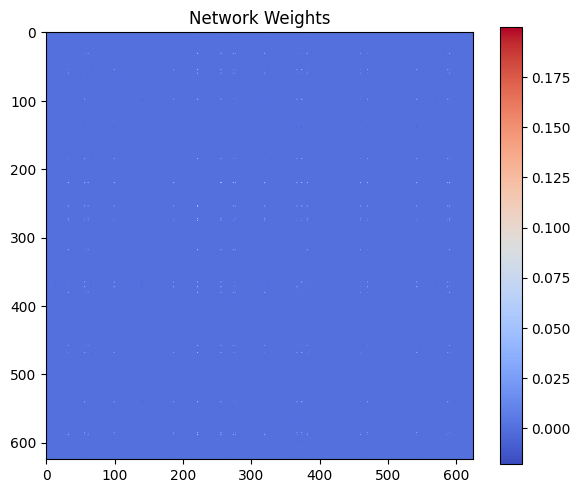

In [429]:
hopfield_model.plot_weights()

In [430]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, h, d_model, d_context, d_output):
        super(Attention, self).__init__()
        self.h = h
        self.d_k = d_model // h
        self.d_v = d_context
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_output)

    def forward(self, z):
        if len(z.shape) == 1:
            batch_size = 1
        else:
            batch_size = z.shape[0]
        
        zz = z.view(batch_size, self.d_k)
        q = zz[:, :]
        k = zz[:, :]
        v = zz[:, :]
        
        query = self.q_linear(q)
        key = self.k_linear(k)
        value = self.v_linear(v)
        
        key_t = key.transpose(-2, -1)
        scores = torch.matmul(query, key_t) / math.sqrt(self.d_k)
        for x in range(self.d_v):
            for y in range(self.d_v):
                if y < x:
                    scores[:, x, y] = torch.zeros((batch_size))
                    
        p_attn = F.softmax(scores, dim=-1)

        x = torch.matmul(p_attn, value)

        x = self.out_linear(x)
        x = torch.sum(x, 1)
        return x

### Visualization

This is what is really stored in memory. Trying to grasp what kind of transformation happens in these three networks.

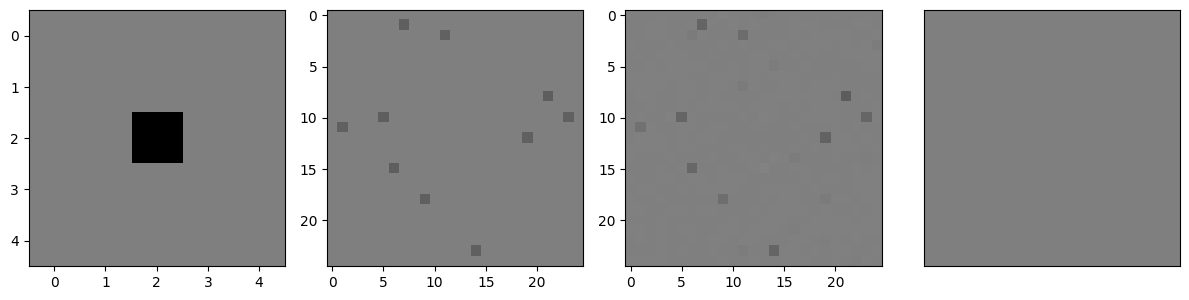

In [431]:
cmap = plt.cm.gray
norm = plt.Normalize(vmin=-1, vmax=1)

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)


# Plot the figure
#plt.figure(figsize=(6, 4))
#plt.imshow(x, cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

## Mapping and reconstruction

This is the last block that is mainly used for retrieval.  

In [432]:
class MappingModel(nn.Module):
    """
    Goal: pattern mapping
    Methods: compare what stored in memory with the original
    """
    
    def __init__(self, input_size, hidden_size, output_size):
        super(MappingModel, self).__init__()
        
        # Layers for mapping and reconstruction
        self.fc_map = nn.Linear(input_size, hidden_size)  # Map Hopfield output to hidden representation
        self.fc_reconstruct = nn.Linear(hidden_size, output_size)  # Reconstruct to original size

    def forward(self, x):
        """
        Forward pass compares stored Hopfield output with the original input
        """
        # Map the Hopfield output to a hidden representation
        mapping = self.fc_map(x)
        hidden_repr = torch.relu(mapping)
        reconstructed_input = self.fc_reconstruct(hidden_repr)
        return reconstructed_input

In [433]:

# Instantiate the model
ca1_model = MappingModel(input_size, hidden_size, output_size)

# Define optimizer (e.g., Adam)
ca1_optimizer = optim.Adam(ca1_model.parameters(), lr=0.0001)

ca1_criterion = nn.MSELoss() # good for comparing pixel values

def forward_ca1_model(ca1_model, u, x):
    ca1_input = torch.cat([u, x]) # u -> K, x -> N
    # Compare reconstruction with the original input
    v = ca1_model(ca1_input)
    return v
    
def train_ca1_model(ca1_model, u, x, a):
    # Zero the parameter gradients
    ca1_optimizer.zero_grad()

    v = forward_ca1_model(ca1_model, u, x)
    loss = ca1_criterion(v, a)

    # Backward pass: compute gradients
    loss.backward()

    # Optimization step: update weights
    ca1_optimizer.step()

    print("Loss:", loss.item())
    print("Reconstructed Input:", v)
    
    return v

Loss: 0.368485689163208
Reconstructed Input: tensor([ 0.0190, -0.0385,  0.0241, -0.0324, -0.0301,  0.0026, -0.0186,  0.0148,
         0.0451,  0.0197, -0.0081, -0.0134, -0.0511, -0.0319, -0.0107, -0.0274,
        -0.0123, -0.0446, -0.0366,  0.0102,  0.0400,  0.0198,  0.0245, -0.0321,
         0.0005], grad_fn=<AddBackward0>)
Loss: 0.36774688959121704
Reconstructed Input: tensor([ 0.0183, -0.0379,  0.0251, -0.0317, -0.0294,  0.0020, -0.0180,  0.0157,
         0.0442,  0.0192, -0.0072, -0.0124, -0.0499, -0.0310, -0.0096, -0.0268,
        -0.0117, -0.0438, -0.0359,  0.0096,  0.0392,  0.0192,  0.0255, -0.0315,
        -0.0002], grad_fn=<AddBackward0>)
Loss: 0.36700916290283203
Reconstructed Input: tensor([ 0.0176, -0.0373,  0.0261, -0.0309, -0.0287,  0.0015, -0.0175,  0.0166,
         0.0433,  0.0187, -0.0063, -0.0114, -0.0487, -0.0300, -0.0085, -0.0262,
        -0.0111, -0.0429, -0.0352,  0.0090,  0.0384,  0.0186,  0.0264, -0.0308,
        -0.0005], grad_fn=<AddBackward0>)
Loss: 0.3662727

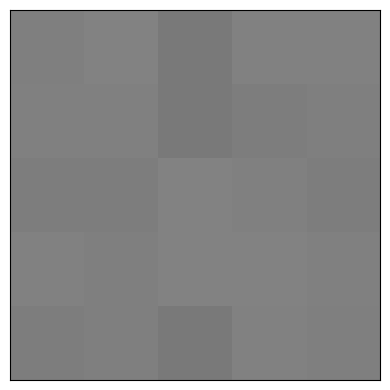

In [434]:
a = output_1.flatten()
aa = output_2.flatten()

for i in range(30):
    v = train_ca1_model(ca1_model, u, x, a)


# Plot the figure
plt.figure(figsize=(6, 4))
plt.imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

In [435]:

# x = input_2.flatten()
# a = output_2.flatten()

# y = forward_dg_model(dg_model, x)
# z, _ = train_ec_to_ca3_model(ec_model, x, y)
# u = train_ca3_memory_model(hopfield_model, y, z)
# v = train_ca1_model(ca1_model, u, x, a)


In [436]:
# fig, axs = plt.subplots(1, 5, figsize=(12, 4))
# axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
# axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
# axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
# axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
# axs[4].imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)

# plt.xticks([])  # No ticks on x axis
# plt.yticks([])  # No ticks on y axis
# plt.tight_layout()
# plt.grid(False)
# plt.show()

Loss: 0.35842373967170715
Reconstructed Input: tensor([-1.1726e-02, -5.4779e-03,  3.8892e-02, -2.3099e-02, -3.4835e-02,
         1.8366e-02,  1.4700e-02,  3.5835e-02,  3.0354e-02,  9.5167e-03,
         7.8821e-05, -2.0098e-03, -2.4587e-02, -1.9946e-02,  3.0959e-02,
        -1.0940e-02, -5.4281e-04, -1.8992e-02,  2.1655e-02, -8.8690e-03,
         3.3497e-02, -1.7320e-04,  4.5350e-02, -2.2795e-02, -2.6122e-02],
       grad_fn=<AddBackward0>)
Loss: 0.35743817687034607
Reconstructed Input: tensor([-1.1632e-02, -4.8079e-03,  3.9337e-02, -2.1998e-02, -3.3570e-02,
         1.7655e-02,  1.4570e-02,  3.6392e-02,  2.9905e-02,  1.0658e-02,
         8.2041e-04, -1.0997e-03, -2.3598e-02, -1.8955e-02,  3.2357e-02,
        -1.0319e-02, -4.8774e-05, -1.8235e-02,  2.2114e-02, -7.5503e-03,
         3.4580e-02,  1.1900e-03,  4.6821e-02, -2.1185e-02, -2.4497e-02],
       grad_fn=<AddBackward0>)
Loss: 0.3561328947544098
Reconstructed Input: tensor([-0.0114, -0.0040,  0.0396, -0.0207, -0.0318,  0.0167,  0.0

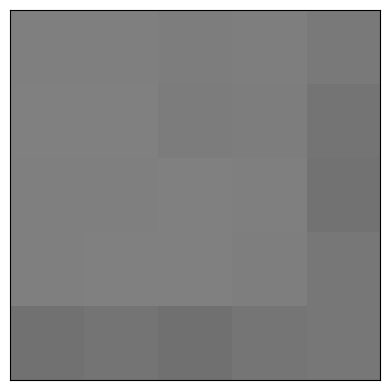

In [437]:
# Another step
for i in range(30):
    vv = train_ca1_model(ca1_model, uu, xx, aa)


plt.figure(figsize=(6, 4))
plt.imshow(vv.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

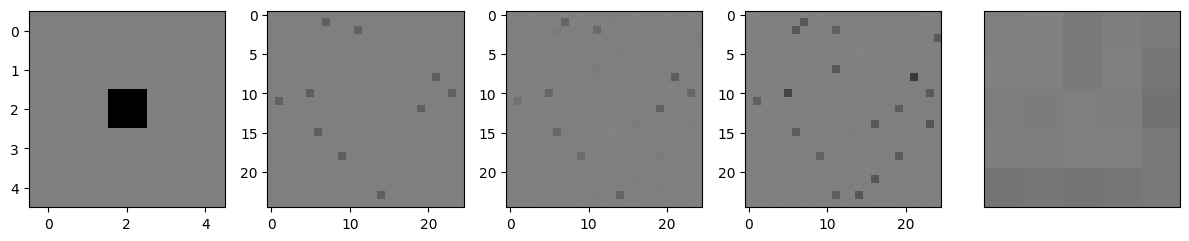

In [438]:

x = input_1.flatten()
a = output_1.flatten()

with torch.no_grad():
    y = forward_dg_model(dg_model, x)
    z = forward_ec_to_ca3_model(ec_model, x)
    u = forward_ca3_memory_model(hopfield_model, z)
    v = forward_ca1_model(ca1_model, u, x)

    fig, axs = plt.subplots(1, 5, figsize=(12, 4))
    axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
    axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[4].imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)

plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

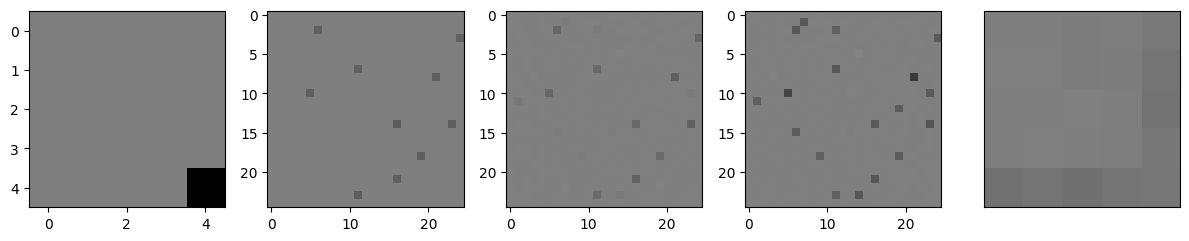

In [439]:
x = input_2.flatten()
a = output_2.flatten()

with torch.no_grad():
    y = forward_dg_model(dg_model, x)
    z = forward_ec_to_ca3_model(ec_model, x)
    u = forward_ca3_memory_model(hopfield_model, z)
    v = forward_ca1_model(ca1_model, u, x)

    fig, axs = plt.subplots(1, 5, figsize=(12, 4))
    axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
    axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[4].imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)

plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

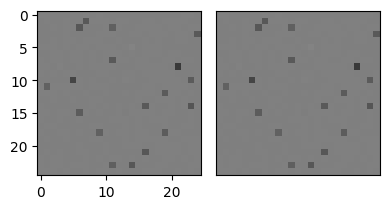

In [440]:

with torch.no_grad():
    x1 = input_1.flatten()
    a1 = output_1.flatten()

    y1 = forward_dg_model(dg_model, x1)
    z1 = forward_ec_to_ca3_model(ec_model, x1)
    u1 = forward_ca3_memory_model(hopfield_model, z1)

    x2 = input_2.flatten()
    a2 = output_2.flatten()

    y2 = forward_dg_model(dg_model, x2)
    z2 = forward_ec_to_ca3_model(ec_model, x2)
    u2 = forward_ca3_memory_model(hopfield_model, z2)


    fig, axs = plt.subplots(1, 2, figsize=(4, 4))
    axs[0].imshow(u1.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[1].imshow(u2.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)


plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()